Simple Conv d1

In [264]:
#チェック用データ取り込み

import numpy as np
# フォワードプロバケーション
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
# a = np.array([35, 50])

# バックプロバケーション
delta_a = np.array([10, 20])
# delta_b = np.array([30])
# delta_w = np.array([50, 80, 110])
# delta_x = np.array([30, 110, 170, 140])

In [266]:
w.shape

(3,)

テスト実行例（復習用に残してます）

In [45]:
#　フォワードプロバケション
fp=np.zeros(w.shape[0]-1)
for i in range(w.shape[0]-1):
    total=0
    for s in range(w.shape[0]):
        total+=x[i+s]*w[s]
    fp[i]=(total+b)

In [32]:
fp

array([35., 50.])

In [64]:
#　バックプロバケーション
dw=np.zeros(w.shape[0])
db=np.sum(delta_a)
for s in range(w.shape[0]):
    total=0
    for i in range(fp.shape[0]):
        total+=delta_a[i]*x[i+s]
    dw[s]=total


In [65]:
dw

array([ 50.,  80., 110.])

In [88]:
# 前の層に流す誤差
dx=np.zeros(x.shape[0])
for j in range(x.shape[0]):
    total=0
    for s in range(w.shape[0]):
        if not(j-s<0 or j-s>fp.shape[0]-1):
            total+=delta_a[j-s]*w[s]
        else :
            total+=0
    dx[j]=total

In [89]:
dx

array([ 30., 110., 170., 140.])

【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [96]:
class SimpleConv1d: 
    
    def __init__(self,n_nodes1, n_nodes2,initializer,optimizer,lr):        
        self.lr=lr      
        self.n_nodes1=n_nodes1
        self.n_nodes2=n_nodes2
        self.initializer = initializer
        self.W1=self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B1=self.initializer.B(self.n_nodes2)        
        self.optimizer = optimizer
        self.A=np.zeros(self.W1.shape[0]-1) 
        
    def forward(self, X):
        A=np.zeros(self.W1.shape[0]-1) 
        for i in range(self.W1.shape[0]-1):
            total=0
            for s in range(self.W1.shape[0]):
                total+=X[i+s]*self.W1[s]
            A[i]=(total+self.B1)
            self.A=A
        return A
    
    def backward(self,X):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # self.totalはソフトマックス関数の中の交差エントロピー
        
        self.DW1=np.zeros(self.W1.shape[0])
        self.DB1=np.sum(self.total)
        for s in range(self.total.shape[0]):
            total=0
            for i in range(self.A.shape[0]):
                total+=self.total[i]*X[i+s]
            self.DW1[s]=total
            
        dX=np.zeros(X.shape[0])
        for j in range(X.shape[0]):
            total=0
            for s in range(self.W1.shape[0]):
                if not(j-s<0 or j-s>self.A.shape[0]-1):
                    total+=self.total[j-s]*self.self.W1[s]
                else :
                    total+=0
            dX[j]=total

        # 更新
        self.B1 = self.B1-self.lr*self.DB1
        self.W1 = self.W1-self.lr*self.DW1
    
        return dX

【問題2】1次元畳み込み後の出力サイズの計算

In [133]:
def size_output(Nin,P,F,S):
    """
    Nin : 入力のサイズ（特徴量の数）
    P : ある方向へのパディングの数
    F : フィルタのサイズ
    S : ストライドのサイズ   
    """
    N_out=int(((Nin+2*P-F)/S)+1)
    return N_out

【問題3】小さな配列での1次元畳み込み層の実験(問題１のクラスをサンプル出力用に少し書き換えた)

In [141]:
class SimpleConv1d: 
    
    def __init__(self,lr):        
        self.lr=lr      
        
    def forward(self, X,W,B):
        A=np.zeros(W.shape[0]-1) 
        for i in range(W.shape[0]-1):
            total=0
            for s in range(W.shape[0]):
                total+=X[i+s]*W[s]
            A[i]=(total+B)
            self.A=A
        return A
    
    def backward(self,X,W,B,delta_a):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # self.totalはソフトマックス関数の中の交差エントロピー
        
        self.DW1=np.zeros(W.shape[0])
        self.DB1=np.array(np.sum(delta_a))
        for s in range(W.shape[0]):
            total=0
            for i in range(self.A.shape[0]):
                total+=delta_a[i]*X[i+s]
            self.DW1[s]=total
            
        dX=np.zeros(X.shape[0])
        for j in range(X.shape[0]):
            total=0
            for s in range(W.shape[0]):
                if not(j-s<0 or j-s>self.A.shape[0]-1):
                    total+=delta_a[j-s]*W[s]
                else :
                    total+=0
            dX[j]=total

        # 更新
        self.B1 = B-self.lr*self.DB1
        self.W1 = W-self.lr*self.DW1
    
        return dX

In [142]:
X = np.array([1,2,3,4])
W = np.array([3, 5, 7])
B = np.array([1])
delta_a = np.array([10, 20])
lr=0.01
SC1=SimpleConv1d(lr)

In [143]:
# フォワードプロバケーションを出力、テキストに書いてある期待される値と同じになった
SC1.forward(X,W,B)

array([35., 50.])

In [149]:
# バックプロバケーションを出力、テキストに書いてある期待される値と同じになった
print(SC1.backward(X,W,B,delta_a))
print(SC1.DW1)
print(SC1.DB1)

[ 30. 110. 170. 140.]
[ 50.  80. 110.]
30


【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [427]:
# データ取り込み
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) 
w = np.ones((3, 2, 3)) 
b = np.array([1, 2, 3]) 

In [164]:
#　出力の特徴量の数
N_out=size_output(4,0,3,1)

In [423]:
#　仮の実行サンプル
fp=np.zeros(int(N_out)*w.shape[0])
fp1=fp.reshape(w.shape[0],int(N_out))
list_a=[]
#list_a=np.array(list_a)

for k in range(w.shape[0]):
    list_a=[]
    list_a=np.array(list_a)
    for j in range(w.shape[0]-1):
        for i in range(int(N_out)):
            total=0
            for s in range(w.shape[2]):
                total+=x[j,i+s]*w[j,i,s]
            list_a=np.append(list_a,total)
        list_a=list_a.reshape(-1,int(N_out))
        list_a=np.sum(list_a,axis=0)
    fp1[k,:]=list_a+b[k]

In [429]:
#　テキストにて期待される値が返ってきていることがわかった、これをクラス化させる
fp1

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [431]:
fp1.shape

(3, 2)

In [433]:
class SimpleConv1d_A: 
    
    def __init__(self,lr):        
        self.lr=lr      
        
    def forward(self, X,W,B):
        N_out=size_output(X.shape[1],0,W.shape[2],1)
        
        
        fp=np.zeros(int(N_out)*W.shape[0])
        A=fp.reshape(W.shape[0],int(N_out))

        for k in range(W.shape[0]):
            list_a=[]
            list_a=np.array(list_a)
            for j in range(W.shape[0]-1):
                for i in range(int(N_out)):
                    total=0
                    for s in range(W.shape[2]):
                        total+=X[j,i+s]*W[j,i,s]
                    list_a=np.append(list_a,total)
                list_a=list_a.reshape(-1,int(N_out))
                list_a=np.sum(list_a,axis=0)
            A[k,:]=list_a+b[k]
            self.A=A

        return A
    
    def backward(self,X,W,B,delta_a):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # self.totalはソフトマックス関数の中の交差エントロピー
        
        self.DW1=np.zeros(W.shape[0])
        self.DB1=np.array(np.sum(delta_a))
        for s in range(W.shape[0]):
            total=0
            for i in range(self.A.shape[0]):
                total+=delta_a[i]*X[i+s]
            self.DW1[s]=total
            
        dX=np.zeros(X.shape[0])
        for j in range(X.shape[0]):
            total=0
            for s in range(W.shape[0]):
                if not(j-s<0 or j-s>self.A.shape[0]-1):
                    total+=delta_a[j-s]*W[s]
                else :
                    total+=0
            dX[j]=total

        # 更新
        self.B1 = B-self.lr*self.DB1
        self.W1 = W-self.lr*self.DW1
    
        return dX

In [436]:
#　クラスを実行した結果、テキストが期待する値が返ってきている
X=x
W=w
B=b

SCA=SimpleConv1d_A(0.01)
SCA.forward(X,W,B)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

問題５〜問題７は保留としたい

【問題8】学習と推定

In [551]:
#　データの取り込みと処理を行う
import numpy as np
import math 
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [552]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [553]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [563]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [564]:
#　全結合クラス
class FC_B:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2,initializer,optimizer):        
        self.n_nodes1=n_nodes1
        self.n_nodes2=n_nodes2
        self.initializer = initializer
        self.W1=self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B1=self.initializer.B(self.n_nodes2)        
        self.optimizer = optimizer
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        
        A=X@self.W1+self.B1
        self.A=A
        return A

    
    def backward(self,Z,dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
               
        # 「3層目」
        self.B2=np.sum(dA, axis=0)
        self.W2=Z.T@dA
        dZ=dA@self.W1.T
        
        #　参考で残す
        #self.B1=self.B1-self.lr*self.B2
        #self.W1=self.W1-self.lr*self.W2
        
        # 更新
        self.B1,self.W1 = self.optimizer.update(self.B1,self.W1,self.B2,self.W2)
    
        return dZ

In [565]:
# 初期化
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2,)        
        return B

In [566]:
#　最適化
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self,B1,W1,B2,W2):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.B1=B1-self.lr*B2
        self.W1=W1-self.lr*W2
        
        return self.B1,self.W1

In [567]:
# シグモイド関数のクラス
class Sigmo_func:
    """
    活性化関数のシグモイド関数クラス化
    Parameters
    ----------
    """
    def Sigmo_func_f(self, A):
        """
        シグモイド関数のフォワード
        Parameters
        ----------
        """
        self.A=A
        Z=1/(1+np.exp(-A))
        self.Z=Z
        return Z
       
    def Sigmo_func_b(self, Z):
        """
        シグモイド関数のバック
        Parameters
        ----------
        """
        sigmo1=(1-self.Sigmo_func_f(self.A))*self.Sigmo_func_f(self.A)
        A=Z*sigmo1
        return A

In [568]:
# ソフトマックス関数のクラス
class Softmax_func:
    """
    活性化関数のソフトマックス関数のクラス化
    Parameters
    ----------
    """
    def softmax_func_f(self, A):
        """
        ソフトマックス関数
        Parameters
        ----------
        """
        Z=np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1) 
        self.Z=Z
        return Z
       
    def softmax_func_b(self, mini_y_train):
        """
        シグモイド関数
        Parameters
        ----------
        """
        # 交差エントロピー誤差
        L = - np.sum(mini_y_train * np.log(self.Z)) / len(mini_y_train)
        self.total=L
        
        # バックプロバケーション
        A=(self.Z-mini_y_train)/len(self.Z)
        self.A=A
        return A

In [573]:
class ScratchSimpleNeuralNetrowkClassifier_A3():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        
        #  畳み込みを前提とした設定
        SI1=SimpleInitializer_B(1/math.sqrt(X.shape[1]))
        optimizer1=SGD_2(0.01)
        self.FC1 = Conv1d_Arbitrary_Strides(7,SI1,optimizer1,n_in_channels=1, n_out_channels=1, pa=3, stride=2)
        self.activation1=Sigmo_func()
        
        #  シグモイドを前提とした設定
        #SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        #optimizer1=SGD(0.1)
        #self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        #self.activation1=Sigmo_func()
        
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.01)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.01)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1 = self.FC1.forward(mini_X_train)
                #　追加処理
                A1 = A1.reshape(A1.shape[0], A1.shape[-1])
                Z1 = self.activation1.Sigmo_func_f(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.Sigmo_func_f(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.softmax_func_f(A3)
                # バック
                dA3 = self.activation3.softmax_func_b(mini_y_train)
                dZ2 = self.FC3.backward(Z2,dA3)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(Z1,dA2)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                #　追加処理
                dA1 = dA1[:, np.newaxis]
                # 追加処理　mini_X_trainなくす
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            self.loss.append(self.activation3.total)

            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(y_val)            
                self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """     
        
        A1 = self.FC1.forward(X)
        #　追加処理
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.Sigmo_func_f(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.Sigmo_func_f(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.softmax_func_f(A3)
             
        
        #A1=self.FC1.forward(X)
        #Z1=self.activation1.Sigmo_func_f(self.FC1.forward(X))
        #A2=self.FC2.forward(Z1)
        #Z2=self.activation2.Sigmo_func_f(A2)                
        #A3=self.FC3.forward(Z2)
        #Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

In [574]:
class Conv1d_Arbitrary_Strides:
    
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.b_size = b_size
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0,0), (0,0), ((self.b_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.b_size, self.n_in+(self.b_size-1)))
        for i in range(self.b_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        return A
    
    def backward(self, dA):
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.b_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.b_size, self.dA.shape[-1]))
        for i in range(self.b_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        self.optimizer.update(self)
        return dX

In [571]:
def output_size_calculation(n_in, F, P=0, S=1):
    n_out = int((n_in + 2*P - F) / S + 1)
    return n_out

In [572]:
class SGD_2:

    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

In [575]:
ite_num=10
first_nodes=392
second_nodes=400
third_nodes=10

SSNN3=ScratchSimpleNeuralNetrowkClassifier_A3(ite_num, first_nodes,second_nodes,third_nodes,verbose = True)

In [576]:
SSNN3.fit(X_train,y_train, X_val=None, y_val=None)

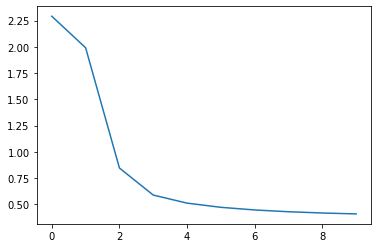

In [577]:
import matplotlib.pyplot as plt
plt.plot(SSNN3.loss)
#plt.plot(SSNN2.val_loss)
plt.show()

In [578]:
# Accuracyは元の初期値よりさらに上がった
y_pred3=SSNN3.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred3)

0.9049

ひとまず９０％ほどの正解率を出すことはできた